In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple, defaultdict, Counter

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
Tag = namedtuple("Tag", ["token", "tag"])
BEGIN_TAG = Tag("^", "<BOS>")
END_TAG = Tag("$", "<EOS>")

def load_sequences(filename, sep="\t", notypes=False):
    sequences = []
    prev_char_tag = "O"
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                if not seq:
                    seq = [BEGIN_TAG]
                line = line.split(sep)
                if notypes:
                    line[1] = line[1][0]
                seq.append(Tag(*line))
            else:
                seq.append(END_TAG)
                sequences.append(seq)
                seq = []
        if seq:
            seq.append(END_TAG)
            sequences.append(seq)
    return sequences
    

In [11]:
train = load_sequences("data/cleaned/train.BIEOU.tsv", notypes=True)
test = load_sequences("data/cleaned/dev.BIEOU.tsv", notypes=True)

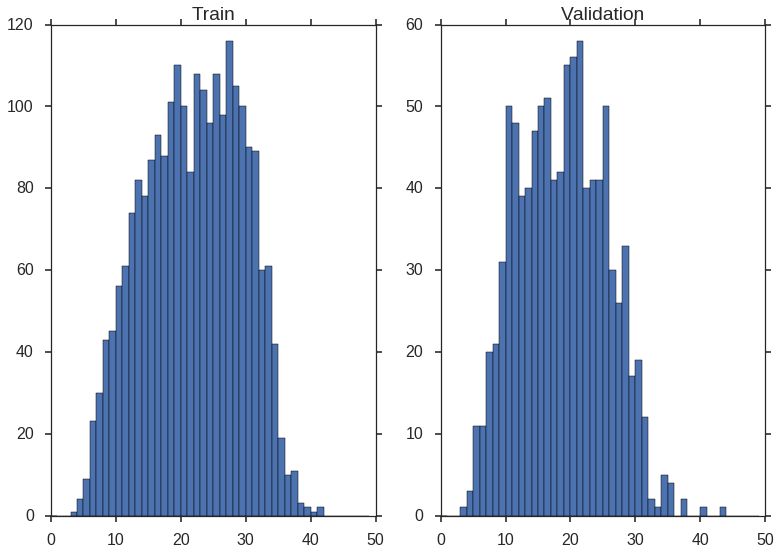

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].hist([len(seq) for seq in train], bins=range(0,50,1))
ax[1].hist([len(seq) for seq in test], bins=range(0,50,1))
ax[0].set_title("Train")
ax[1].set_title("Validation")

In [13]:
labels = sorted(Counter(t.tag for seq in train for t in seq).keys(), key=lambda x: x.split("-")[-1])
labels

['<BOS>', '<EOS>', 'B', 'E', 'I', 'O', 'U']

In [14]:
labels = ["MASK"] + labels
label2id = {l: i for i, l in enumerate(labels)}
label2id

{'<BOS>': 1, '<EOS>': 2, 'B': 3, 'E': 4, 'I': 5, 'MASK': 0, 'O': 6, 'U': 7}

In [21]:
vocab = sorted(Counter(t.token for seq in train for t in seq).keys())
vocab = ["<MASK>", "<OOV>"] + vocab
word2id = {l: i for i, l in enumerate(vocab)}
print len(vocab)

10589


## Modeling

In [18]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, TimeDistributed, Merge, merge
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [43]:
INPUT_DIM=len(vocab)
EMBED_DIM=64
MAXLENGTH=50
NUM_LABELS=len(label2id)

In [22]:
X_train = sequence.pad_sequences([[word2id.get(t.token, word2id["<OOV>"])
                                   for t in seq] for seq in train], maxlen=MAXLENGTH)
X_test = sequence.pad_sequences([[word2id.get(t.token, word2id["<OOV>"])
                                  for t in seq] for seq in test], maxlen=MAXLENGTH)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

('X_train shape:', (2394, 50))
('X_test shape:', (1000, 50))


In [23]:
Y_train = sequence.pad_sequences([[label2id[t.tag] for t in seq] for seq in train], maxlen=MAXLENGTH)
Y_test = sequence.pad_sequences([[label2id[t.tag] for t in seq] for seq in test], maxlen=MAXLENGTH)

train_sample_weight = Y_train != 0
test_sample_weight = Y_test != 0

Y_train = np.expand_dims(Y_train, -1)
Y_test = np.expand_dims(Y_test, -1)


print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)

print('train_sample_weight shape:', train_sample_weight.shape)
print('test_sample_weight shape:', test_sample_weight.shape)

('y_train shape:', (2394, 50, 1))
('y_test shape:', (1000, 50, 1))
('train_sample_weight shape:', (2394, 50))
('test_sample_weight shape:', (1000, 50))


In [44]:
num_layers=3
lstm_units=32
dense_units=32
dropout_p=0.5

input_layer = Input(shape=(MAXLENGTH,), dtype='int32')
emb = Embedding(input_dim=INPUT_DIM, output_dim=EMBED_DIM,
                           input_length=MAXLENGTH, mask_zero=True,
                dropout=dropout_p)(input_layer)
# apply forwards LSTM
forward_lstms = []
prev_layer = emb
for i in xrange(num_layers):
    fw_lstm = LSTM(lstm_units, return_sequences=True,
                   dropout_U=dropout_p, dropout_W=dropout_p)(prev_layer)
    prev_layer = fw_lstm
    forward_lstms.append(fw_lstm)

# apply backwards LSTM
backward_lstms = []
prev_layer = emb
for i in xrange(num_layers):
    bw_lstm = LSTM(lstm_units, return_sequences=True,
                   go_backwards=True, dropout_U=dropout_p, dropout_W=dropout_p)(prev_layer)
    prev_layer = bw_lstm
    backward_lstms.append(bw_lstm)

merged_layer = merge([fw_lstm, bw_lstm], mode="concat")
dropout = Dropout(p=dropout_p)(merged_layer)
dense = TimeDistributed(Dense(dense_units, activation='tanh'))(dropout)
dense2 = TimeDistributed(Dense(dense_units, activation='tanh'))(dense)
out = TimeDistributed(Dense(NUM_LABELS, activation='softmax'))(dense2)

In [45]:
model = Model(input=input_layer, output=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode="temporal",  metrics=['accuracy'])
tb_callback = TensorBoard(log_dir='./tb_logs', histogram_freq=0, write_graph=True)
mc_callback = ModelCheckpoint("models/LSTM1_word.hdf5", monitor='val_loss', save_best_only=True)

In [ ]:
model.fit(X_train, Y_train, nb_epoch=30, batch_size=5,
          sample_weight=train_sample_weight,
         validation_data=(X_test, Y_test, test_sample_weight),
         callbacks=[tb_callback, mc_callback])

/home/entity/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2394 samples, validate on 1000 samples
Epoch 1/30
2394/2394 [==============================] - 142s - loss: 1.6753 - acc: 0.3605 - val_loss: 1.6171 - val_acc: 0.3223
Epoch 2/30
2394/2394 [==============================] - 112s - loss: 1.1358 - acc: 0.3841 - val_loss: 1.4676 - val_acc: 0.3227
Epoch 3/30
2394/2394 [==============================] - 111s - loss: 1.0858 - acc: 0.3870 - val_loss: 1.4444 - val_acc: 0.3227
Epoch 4/30
2394/2394 [==============================] - 112s - loss: 1.0814 - acc: 0.3872 - val_loss: 1.4323 - val_acc: 0.3227
Epoch 5/30
2394/2394 [==============================] - 111s - loss: 1.0686 - acc: 0.3873 - val_loss: 1.4229 - val_acc: 0.3227
Epoch 6/30
2394/2394 [==============================] - 113s - loss: 1.0543 - acc: 0.3874 - val_loss: 1.4017 - val_acc: 0.3227
Epoch 7/30
2394/2394 [==============================] - 110s - loss: 1.0505 - acc: 0.3874 - val_loss: 1.4112 - val_acc: 0.3227
Epoch 8/30
2394/2394 [==============================] - 111s - 

In [47]:
model.history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

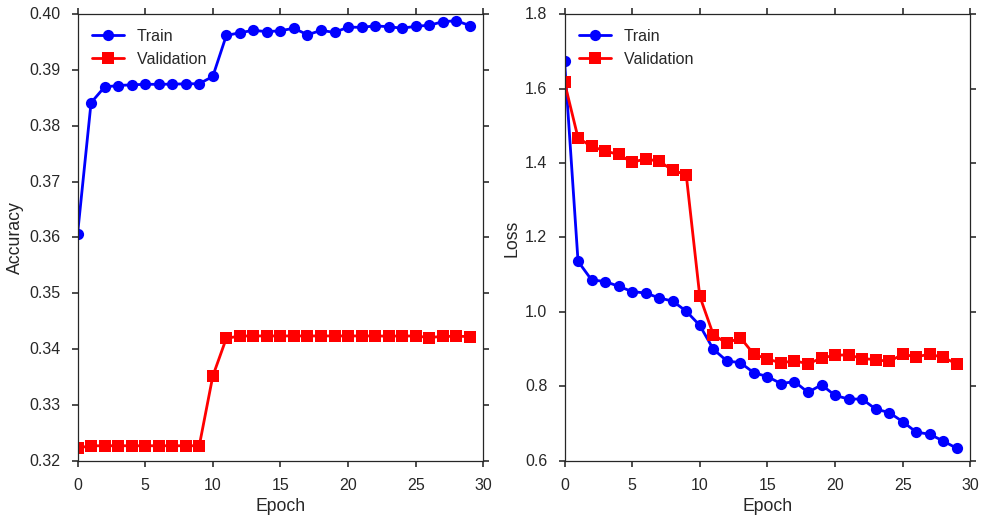

In [48]:
fig, ax = plt.subplots(1,2 ,figsize=(16,8))


ax[0].plot(model.history.epoch, model.history.history["acc"], "-bo", label="Train")
ax[0].plot(model.history.epoch, model.history.history["val_acc"], "-rs", label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

ax[1].plot(model.history.epoch, model.history.history["loss"], "-bo", label="Train")
ax[1].plot(model.history.epoch, model.history.history["val_loss"], "-rs", label="Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

In [49]:
predictions = model.predict(X_train)

In [50]:
predictions.argmax(axis=-1)[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 2])

In [51]:
Y_train[1].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 7, 6,
       6, 6, 6, 6, 6, 6, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3,
       4, 6, 6, 2], dtype=int32)

In [52]:
predictions.argmax(axis=-1)[1] == Y_train[1].flatten()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True], dtype=bool)

In [53]:
predictions_val = model.predict(X_test)

In [54]:
predictions_val.argmax(axis=-1)[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 2])

In [55]:
Y_test[0].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6,
       6, 6, 6, 2], dtype=int32)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
confusion_matrix(Y_train.flatten(),
                            predictions.argmax(axis=-1).flatten(),
                labels=range(len(labels)))

array([[    0, 68443,     0,     0,     0,     0,     0,     0],
       [    0,  2394,     0,     0,     0,     0,     0,     0],
       [    0,     0,  2394,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,   666,     0],
       [    0,     0,     0,     0,     0,     0,   655,     0],
       [    0,     0,     0,     0,     0,     0,   308,     0],
       [    0,     0,    10,     0,     0,     0, 43997,     0],
       [    0,     0,     0,     0,     0,     0,   833,     0]])

In [59]:
confusion_matrix(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)))

array([[ 2394,     0,     0,     0,     0,     0,     0],
       [    0,  2394,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,   666,     0],
       [    0,     0,     0,     0,     0,   655,     0],
       [    0,     0,     0,     0,     0,   308,     0],
       [    0,    10,     0,     0,     0, 43997,     0],
       [    0,     0,     0,     0,     0,   833,     0]])

In [60]:
print classification_report(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)), target_names=labels[1:])

             precision    recall  f1-score   support

      <BOS>       1.00      1.00      1.00      2394
      <EOS>       1.00      1.00      1.00      2394
          B       0.00      0.00      0.00       666
          E       0.00      0.00      0.00       655
          I       0.00      0.00      0.00       308
          O       0.95      1.00      0.97     44007
          U       0.00      0.00      0.00       833

avg / total       0.91      0.95      0.93     51257



/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
df_cfr = confusion_matrix(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)))

df_cfr = pd.DataFrame(df_cfr, index=labels[1:], columns=labels[1:])
df_cfr

,<BOS>,<EOS>,B,E,I,O,U
<BOS>,2394,0,0,0,0,0,0
<EOS>,0,2394,0,0,0,0,0
B,0,0,0,0,0,666,0
E,0,0,0,0,0,655,0
I,0,0,0,0,0,308,0
O,0,10,0,0,0,43997,0
U,0,0,0,0,0,833,0


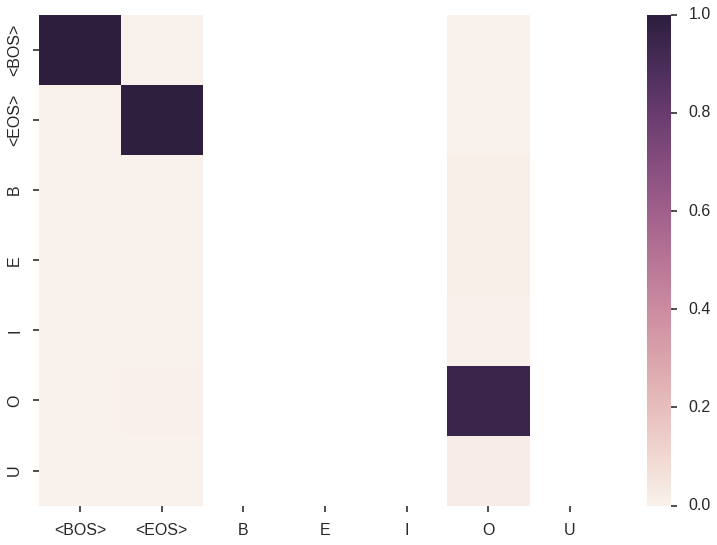

In [62]:
sns.heatmap(df_cfr.divide(df_cfr.sum()))

In [63]:
df_cfr = confusion_matrix(Y_test.flatten()[Y_test.flatten() != 0],
                            predictions_val.argmax(axis=-1).flatten()[Y_test.flatten() != 0],
                labels=range(1,len(labels)))

df_cfr = pd.DataFrame(df_cfr, index=labels[1:], columns=labels[1:])
df_cfr

,<BOS>,<EOS>,B,E,I,O,U
<BOS>,1000,0,0,0,0,0,0
<EOS>,0,1000,0,0,0,0,0
B,0,0,0,0,0,270,0
E,0,0,0,0,0,259,0
I,0,0,0,0,0,204,0
O,0,21,0,0,0,15112,0
U,0,0,0,0,0,395,0


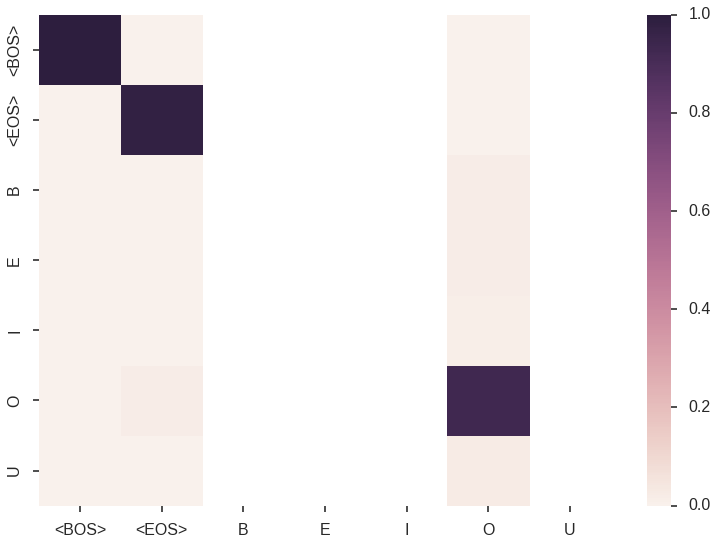

In [64]:
sns.heatmap(df_cfr.divide(df_cfr.sum()))

In [65]:
df_cfr.sum(axis=1)

<BOS>     1000
<EOS>     1000
B          270
E          259
I          204
O        15133
U          395
dtype: int64

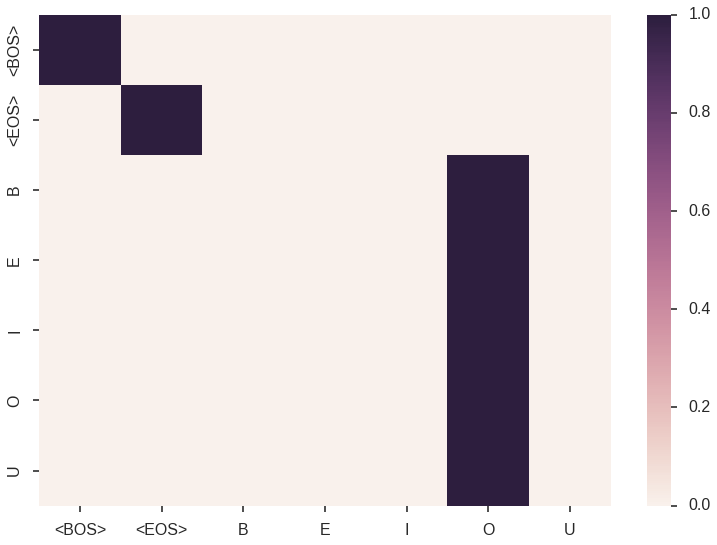

In [66]:
sns.heatmap(df_cfr.divide(df_cfr.sum(axis=1), axis=0))

In [70]:
def write_predictions(data, y_true, y_pred, labels, filename):
    with open(filename, "wb+") as fp:
        for i, seq in enumerate(data):
            y = y_pred[i, (y_true[i, :]!= 0).flatten()]
            for t, pred in zip(seq, y):
                if t.tag in ["<BOS>", "<EOS>"]:
                    continue
                print_line = "%s\t%s\t%s" % (t.token, t.tag, labels[pred])
                if t.token == " ":
                    print_line = "%s\t%s\t%s" % ("<space>", t.tag, labels[pred])
                print >> fp, print_line


In [71]:
write_predictions(test, Y_test, predictions_val.argmax(axis=-1), labels, "dev_notypes.word.tsv")